In [1]:
from sklearn import datasets
from scipy.stats import ttest_ind, levene
import matplotlib.pyplot as plt
import scipy.stats as stats

## One tailed t-test

We will use `diabetes` for an example. The target is a "quantitative measure of disease progression one year after baseline" We will examine if there is a difference in the target based of off `sex`.

In [2]:
dataset = datasets.load_diabetes(as_frame=True, scaled=False)
df = dataset.frame
df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,59.0,2.0,32.1,101.0,157.0,93.2,38.0,4.0,4.8598,87.0,151.0
1,48.0,1.0,21.6,87.0,183.0,103.2,70.0,3.0,3.8918,69.0,75.0
2,72.0,2.0,30.5,93.0,156.0,93.6,41.0,4.0,4.6728,85.0,141.0
3,24.0,1.0,25.3,84.0,198.0,131.4,40.0,5.0,4.8903,89.0,206.0
4,50.0,1.0,23.0,101.0,192.0,125.4,52.0,4.0,4.2905,80.0,135.0


Let's create a boxplot to show the difference in the target by `sex`.

<Axes: title={'center': 'target'}, xlabel='sex'>

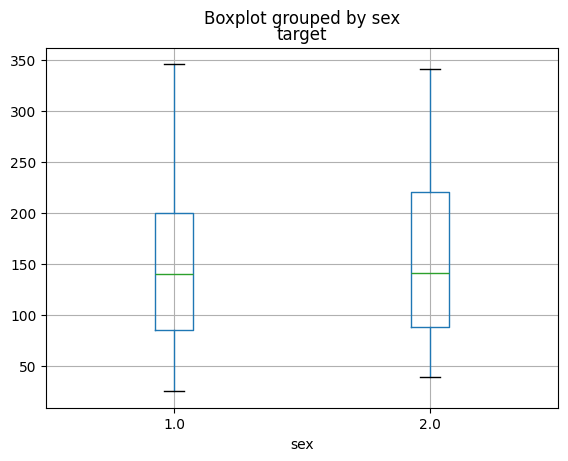

In [3]:
df.boxplot(column="target", by="sex")

Both boxes are very similar, however the box for sex `1` looks like it has slightly lower values (As seen by Q1 and Q3). 

Out of curisoity, let's see some simple stats for each `sex` value.

In [4]:
df.groupby("sex")["target"].describe()

,count,mean,std,min,25%,50%,75%,max
sex,,,,,,,,
1.0,235.0,149.021277,75.905781,25.0,85.5,140.0,200.0,346.0
2.0,207.0,155.666667,78.453313,39.0,88.0,141.0,220.5,341.0


The table above does show that the mean for sex `1` is slightly lower than sex `0`. This raises, the question, is this difference statistically significant?

We now have two groups, in which we want to check that the mean in one is **strictly lower** than the mean in the other. This is a perfect scenario for using a **one tailed t-test** to verify this. We can formulate the above problem thus:

**Hypotheses**
- $ H_0: \mu_1 \geq \mu_2 $ (Group 1 has the same or higher average `target` value)
- $ H_a: \mu_1 < \mu_2 $ (Group 1 has a lower average `target` value)

We shall use an alpha value of 0.05 to determine significance, as it represents a 5% risk of concluding that a difference exists when there is none (Type I error). This is a commonly accepted threshold in hypothesis testing

$$ alpha = 0.05 $$

Create the groups for each `sex` value.

In [5]:
group_1 = df[df["sex"] == 1]["target"]
group_2 = df[df["sex"] == 2]["target"]

Before we perform the hypothesis testing, it is important to highlight some key assumptions:
1. **Independence**
    - Observations must be independant of one another. This assumption is reasonably satisfied with this dataset as each observation represents a unique individual. 
3. **Normality**
    - The target values within each group (`target` column in case) should be approximately normally distributed. Since each group contains 200+ observations (as seen above), the *Central Limit Theorem* suggests that the sampling distribution of the mean will be approximately normal, even if the underlying data is not perfectly normal.
5. **Homoscedacity**
    - Both groups have a similar variance.

### Validating Assumptions

For completeness, the above assumptions will be tested.

#### Independence

As stated above, this assumption is reasonably satisfied.

#### Normality

There are many methods of validating the normality of groups. For this example, we shall use a **Q-Q plot** (quantile-quantile plot). A Q-Q plot compares the quantiles of the sample data against the quantiles of a standard normal distribution. If the data is normally distributed, the points will approximately lie on a straight 45 degree line.

Interpretation:
- Points on the line -> data follows a normal distribution
- Points curving away at the ends -> heavy tails (kurtosis) or skew
- Systematic upward or downward bends -> skewness (left or right)

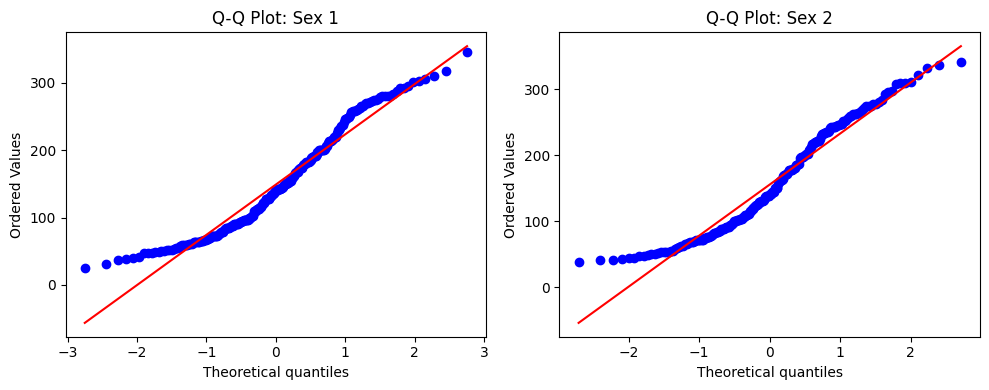

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
stats.probplot(group_1, dist="norm", plot=axs[0])
axs[0].set_title("Q-Q Plot: Sex 1")

stats.probplot(group_2, dist="norm", plot=axs[1])
axs[1].set_title("Q-Q Plot: Sex 2")
plt.tight_layout()
plt.show()

Normality Observations:

- In general, the data points follow the straight 45° line, indicating approximate normality.
- Towards the lower end (~ -3), the points curve upwards away from the line. However, since this pattern is subtle and consistent across both groups, it likely does not meaningfully violate the normality assumption—especially considering the sample size and the robustness of the t-test.

Ideally, we would like to see a closer adherence to the 45 degree line throughout. However, for the purpose of this example, we can accept that the normality assumption is reasonably met.

#### Homoscedacity

Homoscedacity can be tested via visual inspection, or using statistical tests. We shall perform one of each:
1. Boxplot inspection
2. Levene test

**Boxplot Inspection**
  
Firstly, we return to the boxplot plotted previously to perform a visual inspection of the variance between the groups.

<Axes: title={'center': 'target'}, xlabel='sex'>

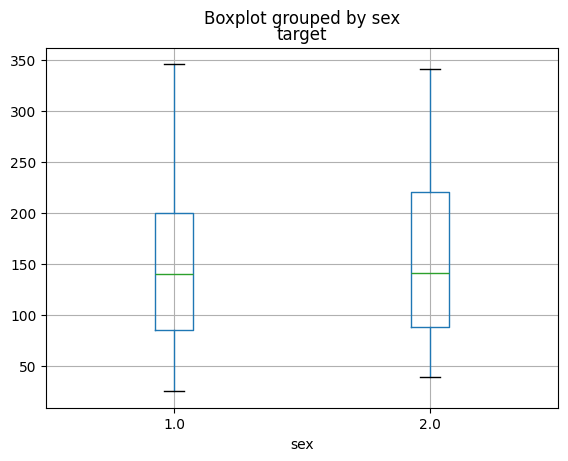

In [7]:
df.boxplot(column="target", by="sex")

Boxplot Observations:
- The IQR for sex `1` is slightly smaller than for sex `2`, indicating a somewhat tighter concentration of middle 50% values in sex `1`.
- The range represented by the whiskers for sex `1` is slightly larger than sex `2`, suggesting that while the core data spread is tighter, the overall spread (including potential outliers) is wider.

**Levene Test**

The Levene test tests the null hypothesis that all samples are from populations with equal variance.

In [8]:
levene_stat, levene_p_stat = levene(group_1, group_2)
print(f"Levene's test statistic: {levene_stat:.4f}")
print(f"p-value: {levene_p_stat:.4f}")

Levene's test statistic: 0.6426
p-value: 0.4232


Levene's Observations:
- A Levene’s test statistic value of 0.6426 indicates that the variance differences between the groups are small relative to the variability within each group. This suggests the groups have similar variances.
- A p-value of 0.4232 is larger than our alpha of 0.05, so we fail to reject the null hypothesis of equal variances.

#### Validating Assumptions - Conclusion

Considering the above results, all key assumptions have been reasonably met: independence, normality (supported by the Q-Q plots), and homoscedasticity (confirmed by boxplot inspection and Levene’s test). This supports the validity of the test conclusions.

### Hypothesis Testing

We shall now use `scipy` to perform a two-tailed t-test. Scipy's `ttest_ind` returns two values:
1. `t-statistic`: How far the sample means are, relative to the variability in the data (larger = more significance)
2. `pvalue`: Probability in oberserving a difference at least as large as the one seen in the data

In [9]:
# equal_var=False performs Welch's t-test which is more robust to different population variances 
t_stat, p_two_tailed = ttest_ind(group_2, group_1, equal_var=False)

As we want to perform a one-tailed t-test, we need to divide the `p` value by two.

In [10]:
if t_stat > 0:
    # t in the expected direction (group1 < group2)
    p_one_tailed = p_two_tailed / 2
else:
    p_one_tailed = 1 - (p_two_tailed / 2)

We can now examine the results:

In [11]:
print(f"t-statistic: {t_stat:.4f}")
print(f"One-tailed p-value: {p_one_tailed:.4f}")

t-statistic: 0.9022
One-tailed p-value: 0.1837


Considering the above results:
- A *t-statistic* value of 0.9022 suggests that the groups means are less than 1 standard error apart. This is not strong evidence that there is a difference.
- A *p-value* of 0.1837 is larger than our alpha of 0.05

In conclusion, based off of the above one-tailed t-test we **fail** to reject the **null** hypothesis as there is insignificant evidence to conclude that a sex of `1` results in a lower `target` value than a sex of `2`.